# Split CSVs

This notebook splits up Athena output from Conflux into individual CSV files for writing to S3.

In [1]:
import pandas as pd

Load the big CSV file into memory:

In [2]:
csv = pd.read_csv('c3_waterbodies_bigquery.csv')

(It's very big.)

First, parse the datetime column.

In [3]:
dates = pd.to_datetime(csv.time, format='%Y%m%d-%H%M%S-%f')

In [4]:
# dates.to_csv('c3_waterbodies_bigquery_dates.csv')

In [5]:
csv['time'] = dates

In [6]:
from tqdm.auto import tqdm

In [7]:
import os

In [8]:
for uid, rows in tqdm(csv.groupby('id'), total=325000):
    path = f'indiv/{uid[:4]}/'
    os.makedirs(path, exist_ok=True)
    filepath = path + f'{uid}.csv'
    if os.path.exists(filepath):
        continue

    # assemble the waterbodies CSV for this ID
    sorted_rows = rows.sort_values('time')[['time', 'px_wet', 'pc_wet']].rename(columns={'time': 'date'})
    sorted_rows['date'] = sorted_rows['date'].dt.round('1s')
    if sorted_rows.date.duplicated().any():
        raise ValueError(f'Duplicate times for {uid}')
    sorted_rows.to_csv(filepath, index=False)

  0%|          | 0/325000 [00:00<?, ?it/s]

In [10]:
import geopandas as gpd

In [13]:
import collections

In [14]:
uid_counts = collections.Counter(csv.id)

In [21]:
import matplotlib.pyplot as plt, numpy as np

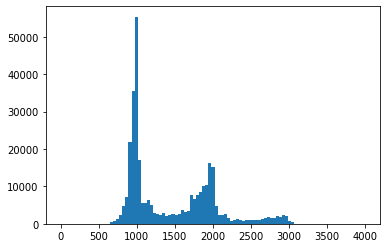

In [22]:
plt.hist(uid_counts.values(), bins=np.linspace(0, 4000, 100));

In [11]:
wbs = gpd.read_file('8b-WB_C3_urls.shp')

In [24]:
missing = set(wbs.uid) - set(uid_counts.keys())

In [28]:
wbs.set_index('uid').loc[list(missing)].to_file('missing_from_c3.gpkg', driver='GPKG')

In [35]:
wbs.iloc[wbs.area.idxmax()]

uid                                              r4ctum36x_v2
url         https://dea-public-data-dev.s3-ap-southeast-2....
geometry    POLYGON ((490860 -3030690, 491010 -3030690, 49...
Name: 179566, dtype: object

In [37]:
kt = pd.read_csv('indiv/r4ct/r4ctum36x_v2.csv')

In [46]:
kt.set_index('date', inplace=True)

In [47]:
kt.index = pd.to_datetime(kt.index)

<AxesSubplot:xlabel='date'>

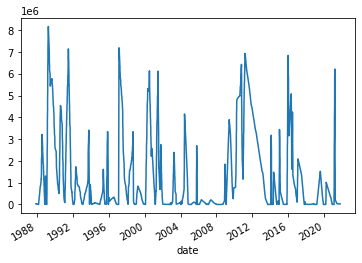

In [48]:
kt.px_wet.interpolate(how='time').plot()

In [50]:
kt2 = pd.read_csv('s3://dea-public-data/projects/WaterBodies/timeseries/r4ct/r4ctk0hzm.csv')

In [53]:
kt2.set_index('Observation Date', inplace=True)
kt2.index = pd.to_datetime(kt2.index)

<AxesSubplot:xlabel='Observation Date'>

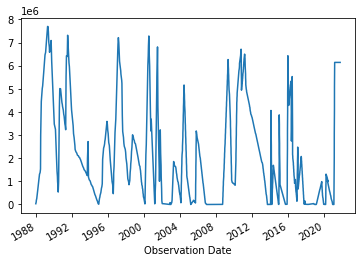

In [55]:
kt2['Wet pixel count (n = 7711917)'].interpolate(how='time').plot()

<AxesSubplot:>

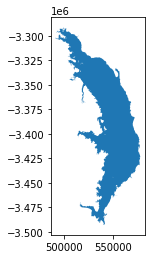

In [63]:
wbs.iloc[[(wbs.bounds.maxy - wbs.bounds.miny).idxmax()]].plot()